In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
def plot_singular_values(matrix, idx):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    return sig

In [6]:
def regular_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter = config_inp['load_counter'] 
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter) + "/non_robust"

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        logger.info("Created model successfully. Now going to load weights")

        #Restore weights
        weights = tf.trainable_variables()
        saver = tf.train.Saver(weights)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

        writer.add_graph(sess.graph)

        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_benign") as scope:
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            logger.info("----Regular test accuracy and loss ----")
            logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_adversarial") as scope:
            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            logger.info("----FGSM test accuracy and loss ----")
            logger.info((loss_fgsm, acc_fgsm))
            x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    return model, sess

In [7]:
def adversarial_training(config):
    eps_train = config['eps_train'] 
    eps_test = config['eps_test'] 
    tensorboard_dir = config['tensorboard_dir'] 
    weights_dir = config['weights_dir']
    load_counter = config['load_counter'] 
    sigma = config['sigma']
    scope_name_rob = config['scope_name']
    sess = tf.Session()
    hidden_sizes = [32,32,32,32,32,32,32]
    
    dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

    with tf.variable_scope(scope_name_rob, reuse = False) as scope:
        logdir = tensorboard_dir + str(counter) + "/robust"
        writer_robust = tf.summary.FileWriter(logdir)
        logger.info("Adversarial Training")
        robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

        print(robust_model.evaluate(sess, x_test_flat, y_test))
        print(robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test))
    return robust_model, sess

In [8]:
def activation_distance(activation_list):
    diff = []
    diff_norms = []
    for i in range(len(activation_list) - 1):
        difference = activation_list[i+1] - activation_list[i]
        diff.append(difference)
        diff_norms.append(np.linalg.norm(difference)/np.linalg.norm(activation_list[i]))
    return diff, diff_norms

## Regular Training

In [9]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 222
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [10]:
config['scope_name']

'model_non_robust'

In [11]:
model_non_robust, sess_non_robust = regular_training(config)

Initialized instance variables of the robust model class
I0828 23:47:02.570277 4608517568 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0828 23:47:02.574556 4608517568 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0828 23:47:02.578690 4608517568 feedforward_robust.py:36] Created placeholders for x and y
W0828 23:47:02.581123 4608517568 deprecation_wrapper.py:119] From ../util.py:31: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0828 23:47:02.583893 4608517568 deprecation_wrapper.py:119] From ../util.py:31: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0828 23:47:02.585281 4608517568 deprecation_wrapper.py:119] From ../util.py:33: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0828 23:47:02.604

In [12]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

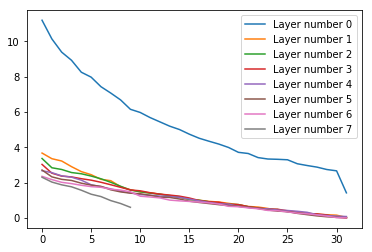

In [13]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals.append(sig)

In [14]:
sing_vals

[array([11.189289 , 10.133197 ,  9.383851 ,  8.92445  ,  8.247922 ,
         7.969636 ,  7.4290295,  7.0685034,  6.6811824,  6.1500745,
         5.970582 ,  5.6832013,  5.439685 ,  5.1961956,  5.0047846,
         4.7424994,  4.5128593,  4.3439555,  4.1835628,  3.9895031,
         3.7153032,  3.6492496,  3.417802 ,  3.3370526,  3.3204548,
         3.294197 ,  3.0694237,  2.9688969,  2.8788092,  2.7434793,
         2.6681807,  1.4231784], dtype=float32),
 array([3.674316  , 3.3551764 , 3.224709  , 2.9054708 , 2.6243584 ,
        2.4510684 , 2.1869967 , 2.1103704 , 1.7720344 , 1.5988731 ,
        1.4801615 , 1.421275  , 1.3496728 , 1.2716495 , 1.1624023 ,
        1.0521415 , 1.0061094 , 0.94067425, 0.904368  , 0.82833225,
        0.75014293, 0.6533072 , 0.61833286, 0.5395455 , 0.42479357,
        0.39901435, 0.33884445, 0.26813343, 0.20976494, 0.18486662,
        0.15978248, 0.03111679], dtype=float32),
 array([3.3668115 , 2.842233  , 2.7448304 , 2.5716846 , 2.5023568 ,
        2.3724024 

In [15]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [16]:
diff_norm

[1.2221951, 1.2958775, 1.2866542, 1.2522035, 1.2535323, 1.1977569]

In [17]:
diff_norm_adv

[1.1699435, 1.2277226, 1.1832038, 1.2514116, 1.2267895, 1.1607223]

In [18]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

In [19]:
dphi_dx_test[0]

array([ 2.57825583e-01,  8.78084004e-02, -7.54263550e-02,  1.16312869e-01,
       -1.05404118e-02,  5.11546850e-01,  1.08980112e-01,  3.60112667e-01,
       -1.30970672e-01,  2.86065906e-01, -2.51386076e-01, -5.32598734e-01,
       -9.00848925e-01, -8.47756684e-01, -4.31117505e-01, -1.08172905e+00,
        3.92692178e-01, -1.76614270e-01, -1.28510660e-02, -8.11763108e-02,
       -3.29416454e-01, -9.48862731e-02, -1.95206463e-01, -9.28842127e-02,
       -5.44355273e-01,  2.50157624e-01,  1.45502254e-01, -1.56610504e-01,
       -2.50830531e-01, -2.74944484e-01, -3.48501772e-01, -3.18996042e-01,
        2.88076341e-01, -3.94406408e-01, -1.00904870e+00, -9.62924361e-01,
       -3.92116129e-01, -6.67419016e-01, -1.37607694e+00, -5.23529112e-01,
       -1.57230663e+00, -1.94908154e+00, -4.86297607e-01, -5.91748834e-01,
       -5.78102291e-01, -1.01870322e+00, -1.40130401e+00, -1.06577003e+00,
       -1.01430583e+00, -1.43360734e+00, -1.34260607e+00, -1.00455070e+00,
        4.18147981e-01, -

In [20]:
dphi_dx_test_non_robust = dphi_dx_test

In [21]:
np.mean(np.abs(dphi_dx_test_non_robust))

0.8664375

In [22]:
adv_images_fgsm = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, 0.10)

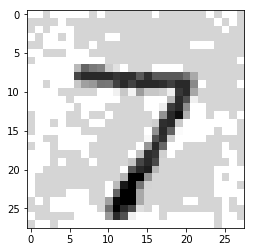

In [23]:
test_image = adv_images_fgsm[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [24]:
diff_fgsm = x_test_flat[0] - adv_images_fgsm[0]

In [25]:
diff_fgsm

array([ 0.1       ,  0.1       , -0.1       ,  0.1       ,  0.1       ,
        0.1       ,  0.1       ,  0.1       , -0.1       ,  0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       ,  0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       ,  0.1       , -0.1       ,
        0.1       ,  0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       ,  0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       ,  0.1       , -0.1       ,  0.1       ,
       -0.1       , -0.1       ,  0.1       , -0.1       ,  0.1       ,
        0.1       ,  0.1       , -0.1       , -0.1       , -0.1       ,
       -0.1       , -0.1       , -0.1       , -0.1       , -0.1 

In [26]:
#adv_images_pgd = model_non_robust.pgd_adam_np(sess_non_robust, x_test_flat, y_test, eps = 0.1, eta = 0.5, num_iter = 20)

In [27]:
loss_pgd, acc_pgd = model_non_robust.adv_evaluate(sess_non_robust, x_test_flat, y_test, 0.40, pgd = True, eta=1e-2, num_iter = 40)

Model is being evaluated on PGD points generated using 0.010000 learning rate and 40 iterations
I0828 23:47:05.689013 4608517568 feedforward_robust.py:301] Model is being evaluated on PGD points generated using 0.010000 learning rate and 40 iterations
W0828 23:47:05.691380 4608517568 deprecation.py:323] From ../feedforward_robust.py:142: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.
W0828 23:47:05.695013 4608517568 deprecation.py:506] From ../feedforward_robust.py:146: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 23:47:05.861209 4608517568 deprecation_wrapper.py:119] From ../feedforward_robust.py:157: The name tf.assign is deprecated. Please use tf.compat.v1.a

iteration: 0
loss 2.308903
iteration: 1
loss 2.313663
iteration: 2
loss 2.317685
iteration: 3
loss 2.321348
iteration: 4
loss 2.324813
iteration: 5
loss 2.328184
iteration: 6
loss 2.331520
iteration: 7
loss 2.334872
iteration: 8
loss 2.338239
iteration: 9
loss 2.341620
iteration: 10
loss 2.345039
iteration: 11
loss 2.348501
iteration: 12
loss 2.352011
iteration: 13
loss 2.355582
iteration: 14
loss 2.359222
iteration: 15
loss 2.362918
iteration: 16
loss 2.366683
iteration: 17
loss 2.370516
iteration: 18
loss 2.374421
iteration: 19
loss 2.378398
iteration: 20
loss 2.382452
iteration: 21
loss 2.386583
iteration: 22
loss 2.390781
iteration: 23
loss 2.395047
iteration: 24
loss 2.399391
iteration: 25
loss 2.403810
iteration: 26
loss 2.408301
iteration: 27
loss 2.412858
iteration: 28
loss 2.417493
iteration: 29
loss 2.422202
iteration: 30
loss 2.426977
iteration: 31
loss 2.431816
iteration: 32
loss 2.436721
iteration: 33
loss 2.441699
iteration: 34
loss 2.446739
iteration: 35
loss 2.451855
it

In [28]:
acc_pgd

0.9528

In [29]:
test_image = adv_images_pgd[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

NameError: name 'adv_images_pgd' is not defined

In [ ]:
difference = test_image - x_test_flat[0]

In [ ]:
max(np.abs(difference))

## Trace regularization for first layer

In [ ]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 121
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [ ]:
config['scope_name']

In [ ]:
reg_model, sess_reg = regular_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = reg_model.get_weights_np(sess_reg)

In [ ]:
#With regularization
sing_vals_reg = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals_reg.append(sig)

**Interpretation** This is pretty interesting. When you penalize the singular values of the first layer, all the other layers start increasing to compensate - I'm guessing to keep the expressiveness high. Probably, if we penalize all the singular values, it may not learn anything?

So we still have not suceeded at replicating the singular value spectrum of the robust model - so it is difficult to conclude whether the singular value spectrum is a determinant of adversarial robustness or not

In [ ]:
#With regularization - first layer
sing_vals_reg

In [ ]:
#Regular points
acts = reg_model.get_activation(sess_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = reg_model.fgsm_np(sess_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = reg_model.get_activation(sess_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

In [ ]:
dphi_dx_robust_first_reg = reg_model.get_dphi_dx(sess_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_first_reg))

# Trace regularization for all layers

In [ ]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 126
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_non_robust"

In [ ]:
model_all_reg, sess_all_reg = regular_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = model_all_reg.get_weights_np(sess_all_reg)

In [ ]:
#With regularization
sing_vals_all = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals_all.append(sig)

In [ ]:
#Regular points
acts = model_all_reg.get_activation(sess_all_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_all_reg.fgsm_np(sess_all_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = model_all_reg.get_activation(sess_all_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

In [ ]:
dphi_dx_robust_all_reg = reg_model.get_dphi_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_all_reg))

# FGSM Adversarial Training

In [ ]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 75
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_robust"

In [ ]:
model_rob, sess_rob = adversarial_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_robust = model_rob.get_weights_np(sess_rob)

In [ ]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx)
    sing_vals_robust.append(sig)

In [ ]:
dphi_dx_robust = model_rob.get_dphi_dx(sess_rob, x_test_flat)
np.mean(np.abs(dphi_dx_robust))

In [ ]:
np.mean(np.abs(dphi_dx_robust))

In [ ]:
sing_vals[0]

In [ ]:
sing_vals_robust[0]

In [ ]:
sing_vals[1]

In [ ]:
sing_vals_robust[1]

In [ ]:
sing_vals[2]

In [ ]:
sing_vals_robust[2]

In [ ]:
sing_vals[-1]

In [ ]:
sing_vals_robust[-1]

In [ ]:
#Regular points
acts = model_rob.get_activation(sess_rob, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_rob.fgsm_np(sess_rob, x_test_flat, y_test, config['eps_test'])
acts_adv = model_rob.get_activation(sess_rob, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

# Comparison plots

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")